In [1]:
## It seems like scale of noisy and clean spectra change because of normalisation or something.
# The GAN copes with this well, as it adpats noisy spectra to match this property of clean spectra.
# But classicasl denoising techniques don't take this into account. 

# This means that when we denoise using classical techniques, we need to somehow account for the 
#normalisation to make the comparison meaningful. 

# Seems like the may have normalised by a peak or something. Not a bad idea.
# i.e. make specrra 1 at same wavenumber where peak occurs
# https://www.impopen.com/subs/jsi/v11/I11_a7.pdf
# https://pubs.acs.org/doi/10.1021/acs.analchem.1c02178

#baseline correct spectra
# normalise by max value
# Then compute MSE

In [2]:
#savistky golay filtering is the most common spectral denoising method.
# we will compare our cycleGAN's denoised spectra to those smoothed with savistky golay filtering
# https://www.datatechnotes.com/2022/05/smoothing-example-with-savitzky-golay.html

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from BaselineRemoval import BaselineRemoval

network_pred = np.load('network_denoised.npy')
network_pred_GT = np.load('network_denoised_GT.npy')
network_pred_input = np.load('network_input.npy')


noisy_va = np.load('hn_valid_set.npy')
clean_va = np.load('ln_valid_set.npy')

In [3]:
#baseline correct and normalise based on max value

for i in range(np.shape(network_pred)[0]):
    
    baseObj=BaselineRemoval(network_pred_GT[i])
    Modpoly_output=baseObj.ModPoly(3)
    network_pred_GT[i] = Modpoly_output/np.max(Modpoly_output)
    
    baseObj=BaselineRemoval(network_pred[i])
    Modpoly_output=baseObj.ModPoly(3)
    #network_pred[i] = Modpoly_output/Modpoly_output[np.where(network_pred_GT[i] == np.max(network_pred_GT[i]))[0][0]]
    network_pred[i] = Modpoly_output/np.max(Modpoly_output)
    
    



In [4]:
network_MSE = np.mean(np.mean((np.squeeze(network_pred) - np.squeeze(network_pred_GT))**2,axis=1))

0.004253629887760413


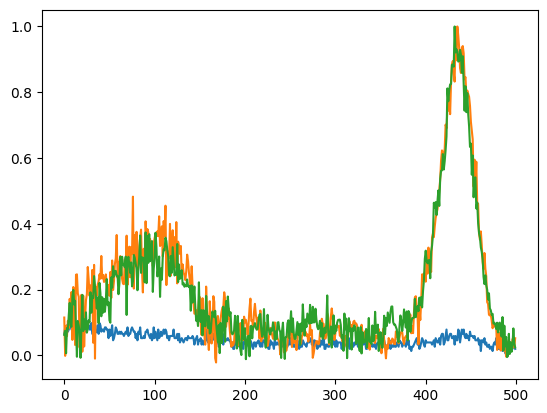

In [5]:
index = 50
print(network_MSE)
plt.plot(network_pred_input[index])
plt.plot(network_pred[index])
plt.plot(network_pred_GT[index])

In [6]:
test_example = np.squeeze(noisy_va[0:100,:])


for i in range(np.shape(test_example)[0]):
    baseObj=BaselineRemoval(test_example[i])
    test_example[i]=baseObj.ModPoly(3)
    

y_smooth = signal.savgol_filter(test_example, window_length=15, polyorder=3, mode="nearest")


In [7]:
np.shape(y_smooth)

(100, 500)

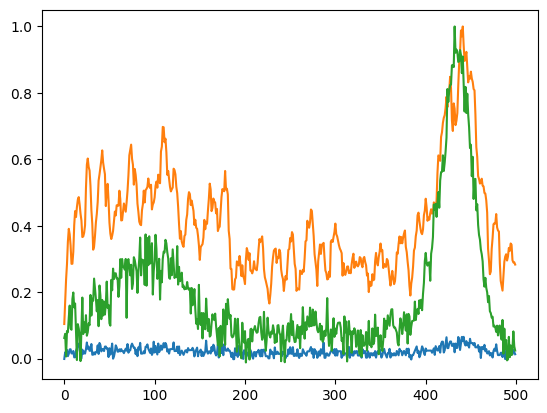

In [8]:
for i in range(np.shape(y_smooth)[0]):
    y_smooth[i] = y_smooth[i]/np.max(y_smooth[i])
    

plt.plot(test_example[index])
plt.plot(y_smooth[index])
plt.plot(network_pred_GT[index])



In [9]:
SG_MSE = np.mean(np.mean((np.squeeze(y_smooth) - np.squeeze(network_pred_GT))**2,axis=1))
print(SG_MSE)

0.06696613532585413


In [10]:
#PCA denoising - https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html

from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=32)
kernel_pca = KernelPCA(
    n_components=400, kernel="rbf", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3
)

pca.fit(noisy_va)
_ = kernel_pca.fit(test_example)

X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
    kernel_pca.transform(test_example)
)


In [11]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(test_example))

In [12]:

for i in range(np.shape(X_reconstructed_pca)[0]):
    X_reconstructed_pca[i] = X_reconstructed_pca[i]/np.max(X_reconstructed_pca[i])

In [13]:
PCA_MSE = np.mean(np.mean((np.squeeze(X_reconstructed_pca) - np.squeeze(network_pred_GT))**2,axis=1))
print(PCA_MSE)

0.05754791052562006


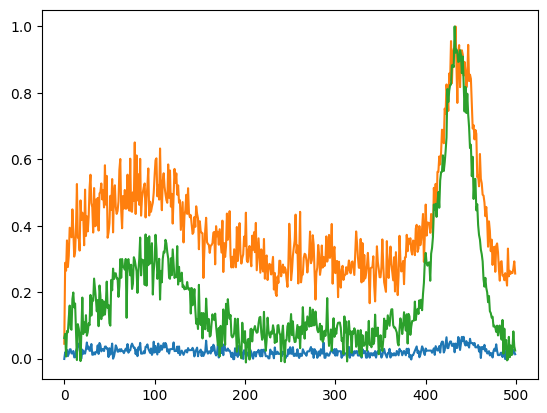

In [14]:
plt.plot(test_example[index])
plt.plot(np.squeeze(X_reconstructed_pca[index]))
plt.plot(network_pred_GT[index])

In [15]:
# Wavelet denoising

In [16]:
import numpy as np
#import PyWavelets as pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt

x_denoise = denoise_wavelet(test_example, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')

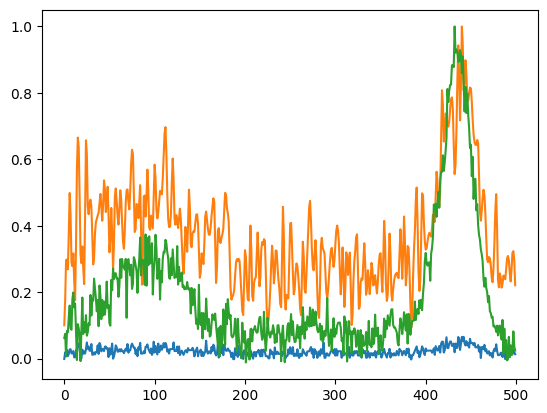

In [17]:
for i in range(np.shape(x_denoise)[0]):
    x_denoise[i] = x_denoise[i]/np.max(x_denoise[i])


plt.plot(test_example[index])
plt.plot(np.squeeze(x_denoise[index]))
plt.plot(network_pred_GT[index])


In [18]:
wav_MSE = np.mean(np.mean((np.squeeze(x_denoise) - np.squeeze(network_pred_GT))**2,axis=1))
print(wav_MSE)

0.05045022529795748


In [19]:
# NOVA metric - https://www.pythonfordatascience.org/anova-python/#test_with_python

import scipy.stats as stats

stats.f_oneway(np.squeeze(x_denoise), test_example)

F_onewayResult(statistic=array([8.63531071e+01, 9.78258375e+01, 7.65482381e+01, 8.62387384e+01,
       8.77021091e+01, 8.83935670e+01, 7.70764067e+01, 8.94257608e+01,
       8.74881668e+01, 9.54492223e+01, 8.60870706e+01, 9.06681680e+01,
       9.68537884e+01, 1.07789586e+02, 8.93835193e+01, 9.74265926e+01,
       9.88839723e+01, 1.12283182e+02, 1.12327441e+02, 1.30922099e+02,
       1.22924396e+02, 1.25038090e+02, 1.06302937e+02, 1.10510503e+02,
       9.90148323e+01, 1.13541088e+02, 1.18781260e+02, 1.20914144e+02,
       1.05950789e+02, 1.41567692e+02, 1.75277792e+02, 2.05840348e+02,
       1.86583150e+02, 2.13737410e+02, 2.13538865e+02, 2.63811010e+02,
       1.89630683e+02, 2.14133879e+02, 1.97049766e+02, 2.75728394e+02,
       2.73505313e+02, 3.48263127e+02, 3.10602704e+02, 3.11869435e+02,
       2.65644457e+02, 2.72881547e+02, 2.43793996e+02, 2.67105229e+02,
       2.34988773e+02, 2.78245422e+02, 2.79217189e+02, 2.86829783e+02,
       2.44418402e+02, 2.69672926e+02, 2.34022600e+0